## Generate data

In [1]:
import numpy as np
import torch
import time
import argparse
from load_data import *
from metrics import *
from trainer import Trainer
from STD_Hunter import *


parser = argparse.ArgumentParser()

parser.add_argument('--device',type=str,default='cuda:0',help='')
parser.add_argument('--dropout',type=float,default=0.5,help='dropout rate')

parser.add_argument('--input_len',type=int,default=12,help='input sequence length')
parser.add_argument('--out_len',type=int,default=1,help='output sequence length')
parser.add_argument('--pred_len',type=int,default=12,help='prediction horizon')
parser.add_argument('--in_dim',type=int,default=4,help='inputs dimension')
parser.add_argument('--rank',type=int,default=4,help='rank')
parser.add_argument('--channels',type=int,default=16,help='channels')

parser.add_argument('--layers',type=int,default=3,help='number of layers')
parser.add_argument('--learning_rate',type=float,default=0.001,help='learning rate')
parser.add_argument('--weight_decay',type=float,default=1e-6,help='weight decay rate')
parser.add_argument('--reg',type=float,default=1e-5,help='regularization coefficient')

parser.add_argument('--epochs',type=int,default=100,help='')
parser.add_argument('--save',type=str,default='save',help='save path')
parser.add_argument('--runs',type=int,default=10,help='number of runs')

args = parser.parse_known_args()[0]


data_path='./'

test_period_point = 168
chla_original, variables = load_data(data_path, test_period_point)

L1 = args.input_len
L2 = args.pred_len
val_period_len = 24
loc, adj, dataloader, scaler = generate_data(variables, L1, L2, test_period_point, val_period_len)

parser.add_argument('--num_nodes',type=int,default=len(loc),help='number of nodes/variables')
args = parser.parse_known_args()[0]
args.dropout = 0

device = torch.device(args.device)
for category in ['train', 'val', 'test']:
    dataloader['X_' + category] = dataloader['X_' + category].to(device)
    dataloader['Y_' + category] = dataloader['Y_' + category].to(device)
scaler = torch.Tensor(scaler).to(device)
adj = adj.to(device)
adj_month = np.diag(np.ones(12))/3
np.fill_diagonal(adj_month[1:], 1/3)
np.fill_diagonal(adj_month[:, 1:], 1/3)
adj_month[0, 11] = 1/3
adj_month[11, 0] = 1/3
adj_month = torch.Tensor(adj_month).to(device)

/home/fzhangat/Ocean/Code/load_data.py:48: RuntimeWarning: Mean of empty slice
  chla_original = np.nanmean(chla_original.reshape([chla_original.shape[0], chla_original.shape[1]//n, n, chla_original.shape[2]//n, n]), axis=(2,4))
/home/fzhangat/Ocean/Code/load_data.py:49: RuntimeWarning: Mean of empty slice
  chla_imputed = np.nanmean(chla_imputed.reshape([chla_imputed.shape[0], chla_imputed.shape[1]//n, n, chla_imputed.shape[2]//n, n]), axis=(2,4))
/home/fzhangat/Ocean/Code/load_data.py:50: RuntimeWarning: Mean of empty slice
  sst = np.nanmean(sst.reshape([sst.shape[0], sst.shape[1]//n, n, sst.shape[2]//n, n]), axis=(2,4))
/home/fzhangat/Ocean/Code/load_data.py:65: RuntimeWarning: Mean of empty slice
  sst = -(sst-np.nanmean(sst[:test_period_point], axis=0))/np.nanstd(sst[:test_period_point], axis=0)*np.nanstd(chla_imputed[:test_period_point], axis=0)+np.nanmean(chla_imputed[:test_period_point], axis=0)
/home/fzhangat/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:187

number of locations: 7806


## Load saved model and characteristics

In [2]:
model = STD_Hunter(args.num_nodes, device, adj=adj, dropout=args.dropout,
              channels=args.channels, seq_length=args.input_len, 
              in_dim=args.in_dim, out_dim=args.out_len, layers=args.layers, rank=args.rank)
model = model.to(device)
engine = Trainer(model, args.learning_rate, args.weight_decay, scaler, device, args.reg)
engine.model.load_state_dict(torch.load(args.save +'.pth'))

characteristics = engine.model.characteristics.data
characteristics = torch.matmul(adj_month, characteristics)
for t in range(12):
    characteristics[:,t] = torch.matmul(adj, characteristics[:, t])        
characteristics = characteristics.detach().cpu().numpy()

## Evaluate model performance

In [3]:
outputs = []
realy = torch.Tensor(dataloader['Y_test']).to(device)
for iter, (x, y) in enumerate(dataloader['test_loader'].get_iterator()):
    testx = torch.Tensor(x).to(device)
    with torch.no_grad():
        preds = engine.model(testx)
    outputs.append(preds.squeeze())
yhat = torch.cat(outputs, dim=0)
yhat = yhat[:realy.size(0), ...]
pred = yhat*scaler[1]+scaler[0]

pred_temp = torch.zeros(pred.shape)
for i in range(12):
    for j in range(len(pred_temp)//12):
        pred_temp[j*12+i] = pred[i*(len(pred_temp)//12)+j]
prediction = np.full(chla_original.shape, np.nan)
prediction[test_period_point:,loc[:,0],loc[:,1]]=pred_temp

mae = []
rmse = []
mape = []
corr = []
for k in range(len(loc)):
    i = loc[k][0]
    j = loc[k][1]
    real = chla_original[test_period_point:, i, j][~np.isnan(chla_original[test_period_point:, i, j])]
    pred = prediction[test_period_point:, i, j][~np.isnan(chla_original[test_period_point:, i, j])]
    error = real-pred
    mae.append(np.mean(np.abs(error)))
    rmse.append(np.sqrt((error ** 2).sum()/len(error)))
    mape.append(np.mean(np.abs(error)/real))
    corr.append(np.corrcoef(real, pred)[0][1])
print(np.mean(mae))
print(np.mean(rmse))
print(np.mean(mape))
print(np.mean(corr))

/home/fzhangat/Ocean/Code/STD_Hunter.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  characteristics = torch.matmul(self.adj, characteristics[:, torch.tensor(month, dtype=torch.long)])


0.024821242534491146
0.04329912334286764
0.1688159450437291
0.6498230977819514


##  Visualize predictions

/tmp/ipykernel_53333/3787030592.py:23: RuntimeWarning: Mean of empty slice
  p1,=axs[i0,j0].plot(time_list,np.nanmean(chla_original[test_period_point:,i:i+7,j:j+7],axis=(1,2)),label='Ground Truth',linewidth=2)


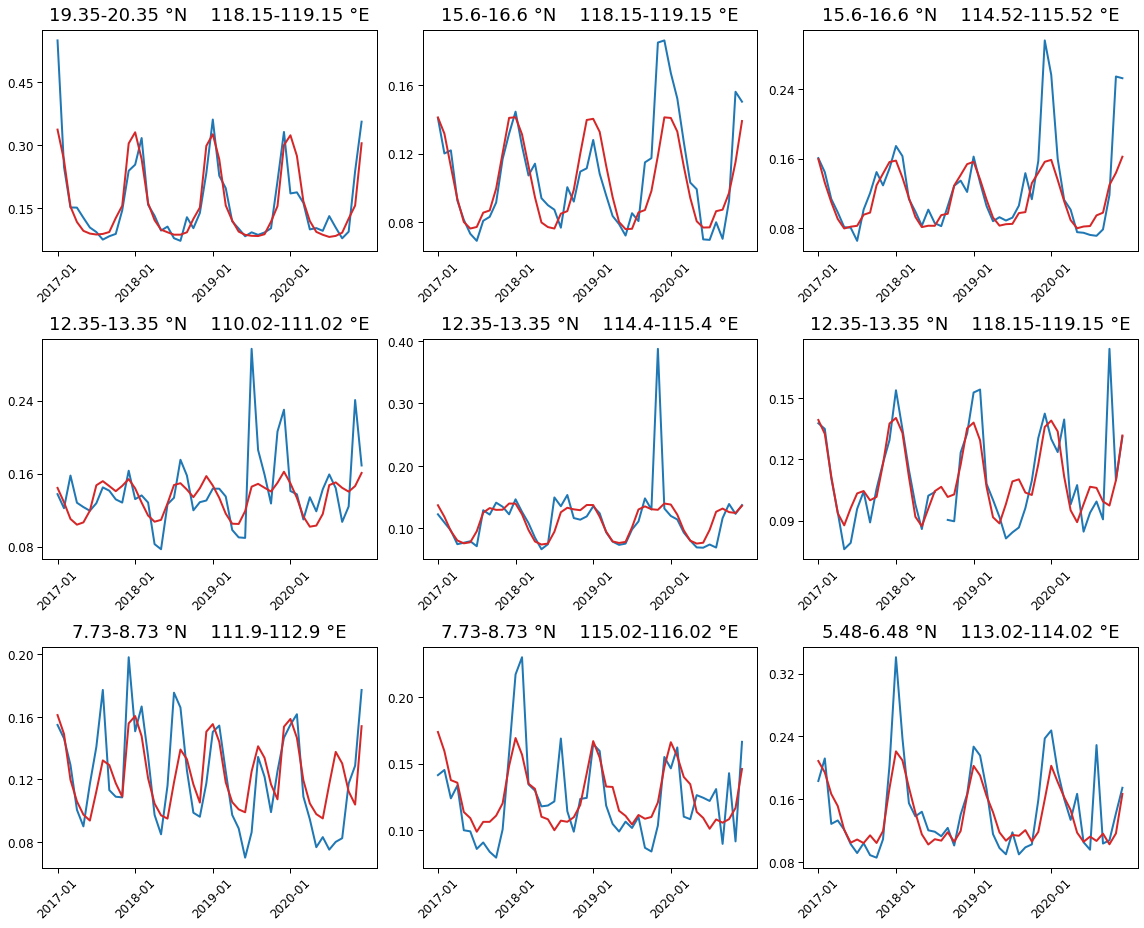

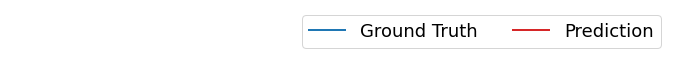

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
from matplotlib.legend_handler import HandlerTuple

temp = h5py.File(data_path+'modis_chla_month_4km_scs_1000m.mat', 'r')
x = list(temp.keys())
latitude = np.array(temp[x[3]])
longitude = np.array(temp[x[4]])

time_list=[]
for year in range(2017, 2021):
    for month in range(12):
        time_list.append(str(year)+'-'+str(month+1).zfill(2))
time_list = np.array(time_list)

loc_list = [[277,185],[307,185],[307,156],[333,120],[333,155],[333,185],[370,135],[370,160],[388,144]]
fig, axs = plt.subplots(3, 3, figsize=(16, 13))
for i0 in range(3):
    for j0 in range(3):
        i=loc_list[i0*3+j0][0]
        j=loc_list[i0*3+j0][1]
        p1,=axs[i0,j0].plot(time_list,np.nanmean(chla_original[test_period_point:,i:i+7,j:j+7],axis=(1,2)),label='Ground Truth',linewidth=2)
        p2,=axs[i0,j0].plot(time_list,np.nanmean(prediction[test_period_point:,i:i+7,j:j+7],axis=(1,2)),label='Prediction',c='#d62728',linewidth=2)
        
        num_ticks=5
        step=int(len(time_list)/(num_ticks-1))
        indices=list(range(0,len(time_list),step))
        axs[i0,j0].set_xticks(time_list[indices])
        axs[i0,j0].set_xticklabels(time_list[indices],rotation=45,fontsize=12)
        axs[i0,j0].tick_params(axis='y', labelsize=12)
        axs[i0,j0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
        axs[i0,j0].yaxis.set_major_locator(MaxNLocator(nbins=4)) 
        axs[i0,j0].tick_params(axis='x',length=5,width=1)
        axs[i0,j0].tick_params(axis='y',length=5,width=1)
        axs[i0,j0].spines['top'].set_linewidth(1)    
        axs[i0,j0].spines['right'].set_linewidth(1)  
        axs[i0,j0].spines['left'].set_linewidth(1)   
        axs[i0,j0].spines['bottom'].set_linewidth(1)
        t1=str(round(latitude[(i+7)*3+3,0],2))+'-'+str(round(latitude[i*3,0],2))+' °N'
        t2=str(round(longitude[0,j*3],2))+'-'+str(round(longitude[0,(j+7)*3+3],2))+' °E'
        axs[i0,j0].set_title(t1+'    '+t2,fontsize=18, pad=10)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9.5,1)) 
legend = plt.legend(
    handles=[(p1),(p2)],
    labels=['Ground Truth','Prediction'],               
    handler_map={tuple: HandlerTuple(ndivide=None)},
    fontsize=18,
    ncol=2
)
plt.axis('off')
plt.tight_layout()
plt.show()

## Partition of South China Sea

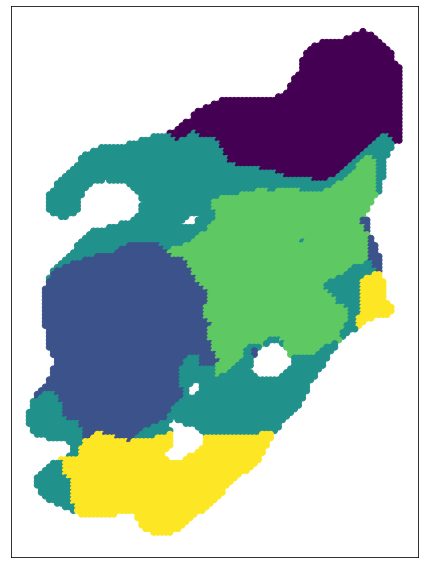

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
characteristics_space = characteristics.reshape(characteristics.shape[0],characteristics.shape[1]*characteristics.shape[2])
kmeans = KMeans(n_clusters=5)
kmeans.fit(characteristics_space)
labels = kmeans.labels_
cmap = plt.cm.get_cmap('viridis')
plt.figure(figsize=(6, 8))
plt.scatter(loc[:,1], loc[:,0].max()-loc[:,0], c=labels, cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

## Spatiotemporal characteristics of the first principal dynamics

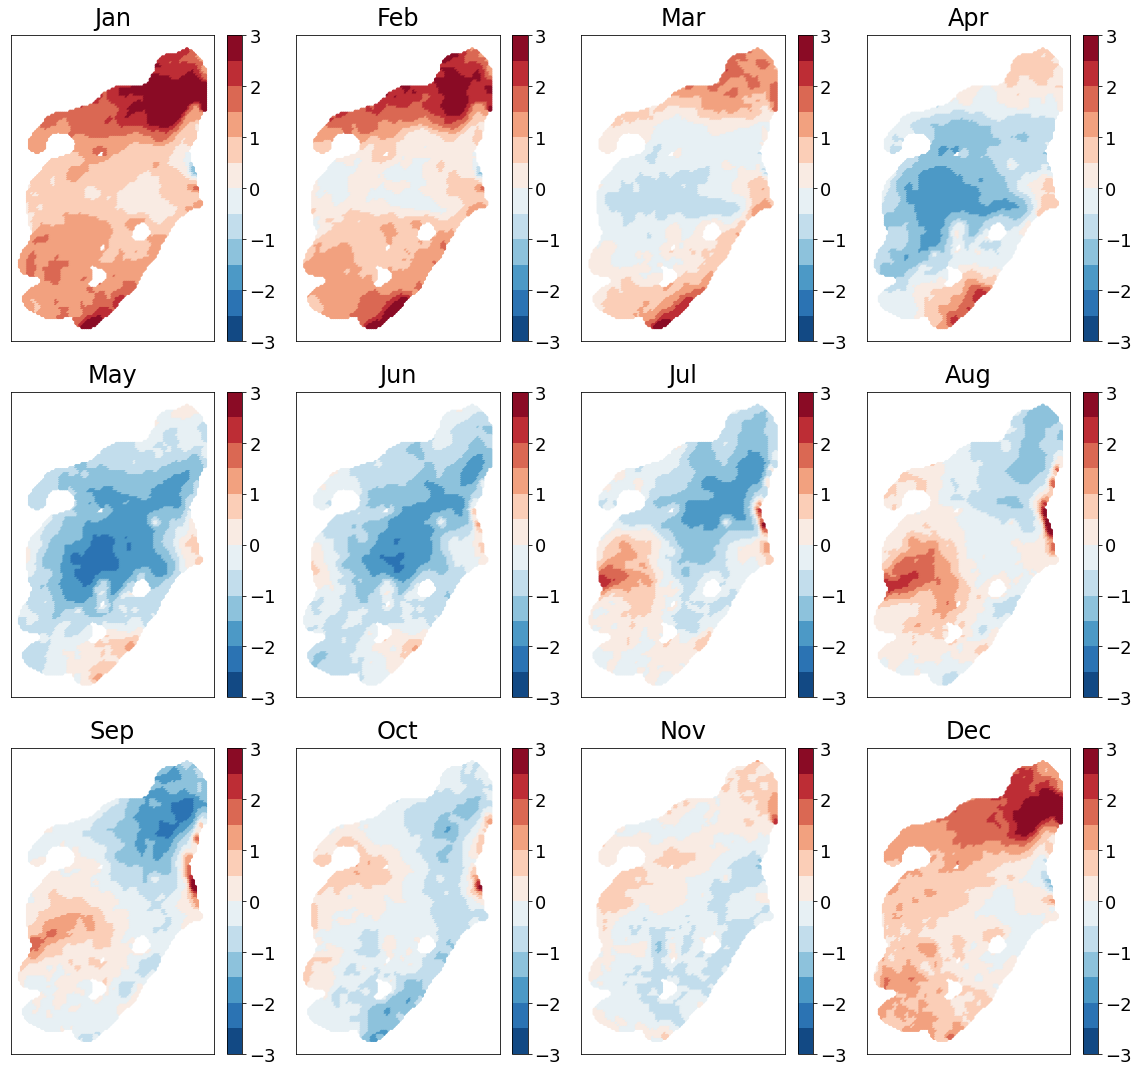

In [6]:
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
characteristics_pca = characteristics.copy()
characteristics_pca = (characteristics_pca-characteristics_pca.reshape(characteristics_pca.shape[0]*characteristics_pca.shape[1],characteristics_pca.shape[2]).mean(axis=0))/characteristics_pca.std()
pca = PCA(n_components=4)
principal_components = pca.fit_transform(characteristics_pca.reshape(characteristics_pca.shape[0]*characteristics_pca.shape[1],characteristics_pca.shape[2]))
characteristics_pca = principal_components.reshape(characteristics.shape)

cmap = plt.get_cmap('RdBu_r')
colors = cmap(np.linspace(0.05, 0.95, 256)) 
temp = [int(256/11*i) for i in range(12)]
temp[-1] -= 1
colors = colors[temp]
cmap_middle = mcolors.ListedColormap(colors)

fig, axs = plt.subplots(3, 4, figsize=(16, 15))
cmap = plt.cm.get_cmap('viridis')
month_list = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for i in range(3):
    for j in range(4):
        temp = -characteristics_pca[:,i*4+j,0]/characteristics_pca[:,:,0].std()
        subfig = axs[i, j].scatter(loc[:,1], loc[:,0].max()-loc[:,0], c=temp, cmap=cmap_middle, s=10)
        axs[i, j].set_title(month_list[i*4+j], fontsize=24, pad=10)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        cbar = fig.colorbar(subfig,ax=axs[i, j])
        cbar.mappable.set_clim(-3, 3) 
        cbar.ax.tick_params(labelsize=18)

plt.tight_layout()
plt.show()